# Playground Series 머신러닝 분석
* https://www.kaggle.com/competitions/playground-series-s3e12/overview/description
### 제출물은 예측 확률과 관찰된 목표 사이의 ROC 곡선 아래 영역에서 평가된다.
* 검정 세트의 각 id에 대해 대상 확률(신장 결석이 있을 가능성)을 예측해야 합니다. 파일에는 헤더가 포함되어야 한다.

In [4]:
# data analysis and wrangling
import pandas as pd
import numpy as np
import random as rnd

# visualization
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline

In [5]:
train = pd.read_csv('playground-series/train.csv')
test = pd.read_csv('playground-series/test.csv')

In [6]:
train.shape, test.shape

((414, 8), (276, 7))

In [7]:
train.head(5)

,id,gravity,ph,osmo,cond,urea,calc,target
0,0,1.013,6.19,443,14.8,124,1.45,0
1,1,1.025,5.40,703,23.6,394,4.18,0
2,2,1.009,6.13,371,24.5,159,9.04,0
3,3,1.021,4.91,442,20.8,398,6.63,1
4,4,1.021,5.53,874,17.8,385,2.21,1


In [8]:
test.head(3)

,id,gravity,ph,osmo,cond,urea,calc
0,414,1.017,5.24,345,11.5,152,1.16
1,415,1.020,5.68,874,29.0,385,3.46
2,416,1.024,5.36,698,19.5,354,13.00


In [9]:
train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 414 entries, 0 to 413
Data columns (total 8 columns):
 #   Column   Non-Null Count  Dtype  
---  ------   --------------  -----  
 0   id       414 non-null    int64  
 1   gravity  414 non-null    float64
 2   ph       414 non-null    float64
 3   osmo     414 non-null    int64  
 4   cond     414 non-null    float64
 5   urea     414 non-null    int64  
 6   calc     414 non-null    float64
 7   target   414 non-null    int64  
dtypes: float64(4), int64(4)
memory usage: 26.0 KB


## 데이터 설명
* id: ID
* gravity: 물에 대한 소변의 밀도
* ph: 수소 이온의 음의 로그.
* osmo: 삼투압. 삼투압은 용액 내 분자의 농도에 비례
* cond: 전도도 (mMho milliMho).  전도도는 용액 내 하전 이온의 농도에 비례한다.
* urea: 요소 농도(리터당 밀리몰 단위).
* calc: 밀리몰셀리트르의 칼슘 농도(CALC).
* target:0: 결석존재하지 않음. 1: 결석 있음.

## EDA 진행

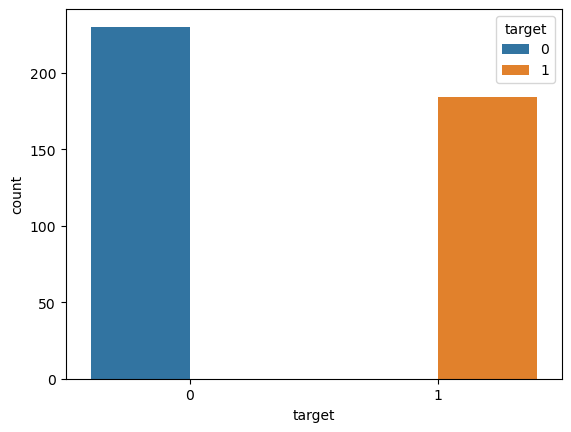

In [11]:
sns.countplot(data=train, x='target', hue='target');

이를 통해 요로결석이 존재하는 사람과 요로 결석이 존재하지 않은 사람의 비율에 큰 차이가 나지 않는다는 것을 알 수 있다.

<AxesSubplot:xlabel='target', ylabel='ph'>

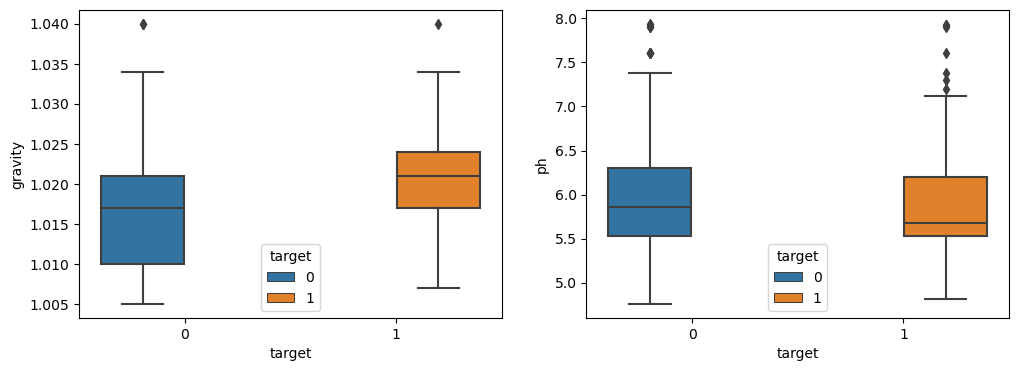

In [16]:
fig, axes = plt.subplots(1, 2, figsize = (12, 4))

sns.boxplot(data=train, ax=axes[0], x='target', y='gravity', hue='target')
sns.boxplot(data=train, ax=axes[1], x='target', y='ph', hue='target')

<AxesSubplot:xlabel='target', ylabel='cond'>

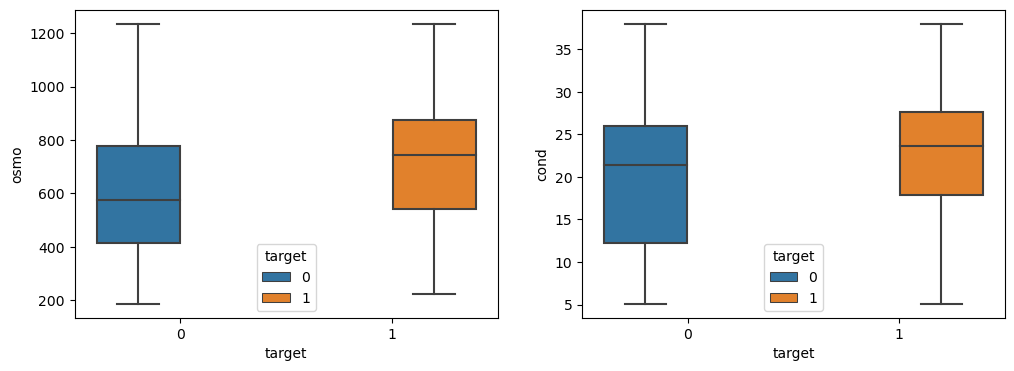

In [17]:
fig, axes = plt.subplots(1, 2, figsize = (12, 4))

sns.boxplot(data=train, ax=axes[0], x='target', y='osmo', hue='target')
sns.boxplot(data=train, ax=axes[1], x='target', y='cond', hue='target')

<AxesSubplot:xlabel='target', ylabel='calc'>

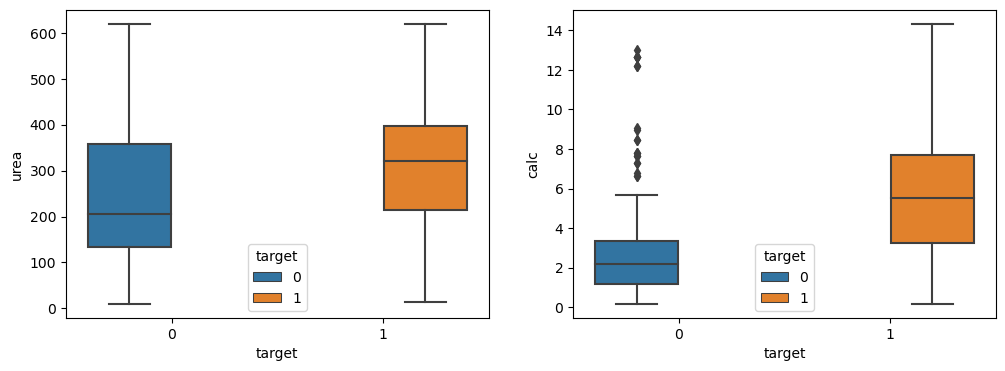

In [18]:
fig, axes = plt.subplots(1, 2, figsize = (12, 4))

sns.boxplot(data=train, ax=axes[0], x='target', y='urea', hue='target')
sns.boxplot(data=train, ax=axes[1], x='target', y='calc', hue='target')

EDA를 통해 calc가 요로결석이 가장 큰 영향을 주는 요소라는 것을 알 수 있었다.

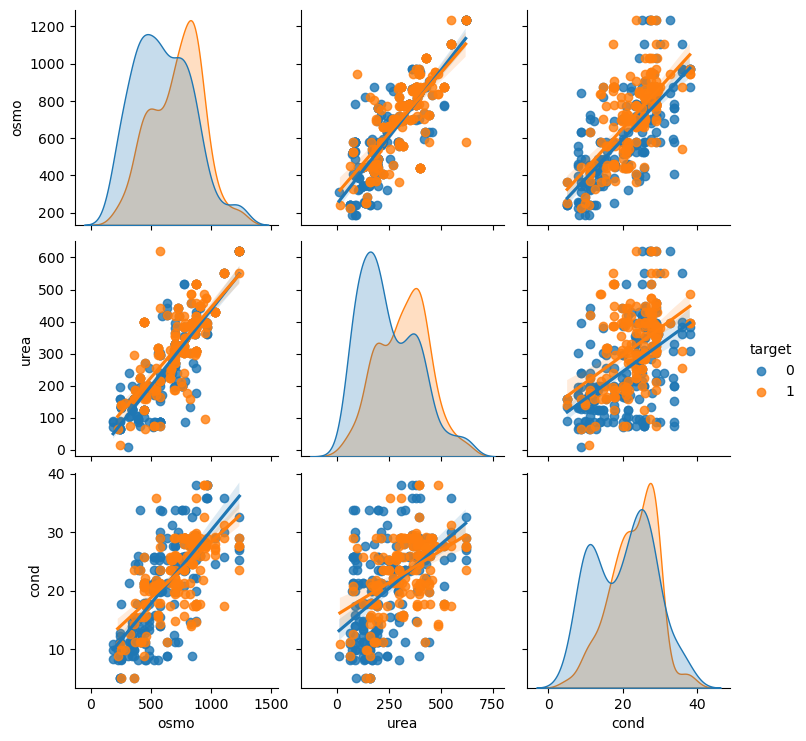

In [28]:
sns.pairplot(train[['osmo', 'urea', 'cond', 'target']], hue='target', kind='reg')

## 머신러닝 돌리기

In [1]:
from sklearn.model_selection import GridSearchCV,train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import roc_curve, auc,make_scorer,confusion_matrix, accuracy_score

from xgboost import XGBClassifier
from lightgbm import LGBMClassifier

In [10]:
X = train.drop('target', axis=1)
y = train['target']

In [11]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=313, stratify = y)

In [12]:
X_train.shape, X_test.shape, y_train.shape, y_test.shape

((331, 7), (83, 7), (331,), (83,))

### XGBClassifier 사용

In [15]:
xgb = XGBClassifier(colsample_bytree = 0.9, learning_rate = 0.1, max_depth = 8 , n_estimators = 1000)
xgb.fit(X_train, y_train)

# test data예측하기
y_pred_xgb = xgb.predict(X_test)

# evaluate predictions
accuracy = accuracy_score(y_test, y_pred_xgb)
print("Accuracy: %.2f%%" % (accuracy * 100.0))

Accuracy: 71.08%


### LGBMClassifier 사용

In [17]:
lgbm = LGBMClassifier(n_estimators = 1000, learning_rate = 0.5,min_child_samples = 10, num_leaves = 125)
lgbm.fit(X_train, y_train)

# test data예측하기
y_pred_lgbm = lgbm.predict(X_test)

# evaluate predictions
accuracy = accuracy_score(y_test, y_pred_lgbm)
print("Accuracy: %.2f%%" % (accuracy * 100.0))

Accuracy: 73.49%


In [52]:
# 네번째 시도
lgbm = LGBMClassifier(n_estimators = 1000, learning_rate = 0.12,min_child_samples = 10, num_leaves = 30)
lgbm.fit(X_train, y_train)

# test data예측하기
y_pred_lgbm = lgbm.predict(X_test)

# evaluate predictions
accuracy = accuracy_score(y_test, y_pred_lgbm)
print("Accuracy: %.2f%%" % (accuracy * 100.0))

Accuracy: 74.70%


In [54]:
y_pred_test_lgbm2 = lgbm.predict(test)

### RandomForestClassifier 사용

In [18]:
rf = RandomForestClassifier(max_depth = 25, max_features = 'auto')
rf.fit(X_train, y_train)

# test data예측하기
y_pred_rf = rf.predict(X_test)

# evaluate predictions
accuracy = accuracy_score(y_test, y_pred_rf)
print("Accuracy: %.2f%%" % (accuracy * 100.0))

Accuracy: 78.31%


In [21]:
y_pred_test_rf = rf.predict(test)
y_pred_test_rf

array([0, 1, 1, 1, 0, 1, 1, 0, 0, 0, 0, 0, 1, 0, 0, 0, 1, 0, 0, 0, 0, 0,
       0, 1, 1, 0, 0, 0, 0, 1, 1, 1, 1, 0, 0, 0, 1, 0, 0, 1, 1, 1, 1, 0,
       1, 0, 1, 0, 1, 0, 1, 1, 0, 0, 1, 0, 1, 0, 1, 1, 1, 0, 1, 0, 0, 1,
       0, 1, 0, 0, 0, 1, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0,
       0, 1, 1, 1, 0, 0, 0, 1, 0, 0, 0, 1, 0, 1, 0, 0, 1, 1, 0, 1, 1, 1,
       0, 0, 1, 0, 0, 0, 0, 1, 0, 1, 0, 0, 0, 0, 0, 0, 1, 1, 0, 0, 1, 0,
       0, 0, 0, 1, 0, 1, 0, 0, 0, 0, 0, 1, 1, 0, 0, 1, 1, 0, 1, 1, 0, 0,
       1, 1, 1, 0, 0, 0, 0, 0, 1, 0, 0, 0, 1, 0, 1, 0, 0, 0, 1, 1, 0, 0,
       1, 0, 1, 1, 1, 1, 0, 0, 0, 0, 0, 0, 1, 0, 0, 1, 1, 1, 1, 0, 0, 0,
       0, 1, 0, 1, 0, 0, 0, 0, 1, 1, 0, 1, 0, 1, 1, 0, 0, 1, 0, 1, 0, 0,
       1, 1, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 1, 1, 0, 0, 0, 0, 1, 1, 0, 0,
       0, 0, 0, 0, 1, 1, 1, 1, 1, 0, 1, 0, 0, 1, 1, 0, 1, 0, 0, 0, 0, 1,
       0, 0, 1, 0, 0, 0, 0, 1, 0, 1, 0, 0], dtype=int64)

In [33]:
# 두번째 시도
rf = RandomForestClassifier(max_depth = 55, criterion='entropy')
rf.fit(X_train, y_train)

# test data예측하기
y_pred_rf = rf.predict(X_test)

# evaluate predictions
accuracy = accuracy_score(y_test, y_pred_rf)
print("Accuracy: %.2f%%" % (accuracy * 100.0))


Accuracy: 79.52%


In [53]:
y_pred_test_rf2 = rf.predict(test)

### 그리드서치 해보기

In [17]:
rf = RandomForestClassifier()


param_grid = {'criterion':['gini','entropy'],
               'max_depth' : range(30),
                'max_leaf_nodes' : ['Any',30,40,50],
                'max_features' : ['auto','sqrt','log2']}

grid_rf = GridSearchCV(rf,param_grid = param_grid, verbose = 1, cv = 10)


grid_rf.fit(X_train,y_train)


Fitting 10 folds for each of 720 candidates, totalling 7200 fits


C:\Users\kelly\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:372: FitFailedWarning: 
1980 fits failed out of a total of 7200.
The score on these train-test partitions for these parameters will be set to nan.
If these failures are not expected, you can try to debug them by setting error_score='raise'.

Below are more details about the failures:
--------------------------------------------------------------------------------
240 fits failed with the following error:
Traceback (most recent call last):
  File "C:\Users\kelly\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py", line 680, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "C:\Users\kelly\anaconda3\lib\site-packages\sklearn\ensemble\_forest.py", line 450, in fit
    trees = Parallel(
  File "C:\Users\kelly\anaconda3\lib\site-packages\joblib\parallel.py", line 1085, in __call__
    if self.dispatch_one_batch(iterator):
  File "C:\Users\kelly\anaconda3\lib\site-packag

GridSearchCV(cv=10, estimator=RandomForestClassifier(),
             param_grid={'criterion': ['gini', 'entropy'],
                         'max_depth': range(0, 30),
                         'max_features': ['auto', 'sqrt', 'log2'],
                         'max_leaf_nodes': ['Any', 30, 40, 50]},
             verbose=1)

In [18]:
RandomForest = grid_rf.best_estimator_

In [19]:
RandomForest

RandomForestClassifier(criterion='entropy', max_depth=19, max_features='log2',
                       max_leaf_nodes=30)

In [20]:
# 세번째 시도
rf = RandomForestClassifier(max_depth = 19, criterion='entropy', max_features='log2', max_leaf_nodes=30)
rf.fit(X_train, y_train)

# test data예측하기
y_pred_rf = rf.predict(X_test)

# evaluate predictions
accuracy = accuracy_score(y_test, y_pred_rf)
print("Accuracy: %.2f%%" % (accuracy * 100.0))


Accuracy: 78.31%


In [21]:
y_pred_test_rf3 = rf.predict(test)

### submission

In [55]:
submit = pd.read_csv('playground-series/sample_submission.csv')


In [56]:
submit['target'] = y_pred_test_lgbm2
submit

,id,target
0,414,0
1,415,1
2,416,1
3,417,0
4,418,1
...,...,...
271,685,1
272,686,0
273,687,0
274,688,0


In [57]:
file_name = "rf_4(74.7).csv"
submit.to_csv(file_name, index=False)
pd.read_csv(file_name)

,id,target
0,414,0
1,415,1
2,416,1
3,417,0
4,418,1
...,...,...
271,685,1
272,686,0
273,687,0
274,688,0


### 오버샘플링해보기

In [24]:
from imblearn.over_sampling import RandomOverSampler
oversampling = RandomOverSampler()
over_X_train,over_y_train = oversampling.fit_resample(X_train,y_train)

In [25]:
rf = RandomForestClassifier(max_depth = 25, max_features = 'auto')
rf.fit(over_X_train, over_y_train)

# test data예측하기
y_pred_rf = rf.predict(X_test)

# evaluate predictions
accuracy = accuracy_score(y_test, y_pred_rf)
print("Accuracy: %.2f%%" % (accuracy * 100.0))

Accuracy: 77.11%


In [27]:
lgbm = LGBMClassifier(n_estimators = 1000, learning_rate = 0.5,min_child_samples = 10, num_leaves = 125)
lgbm.fit(over_X_train, over_y_train)

# test data예측하기
y_pred_lgbm = lgbm.predict(X_test)

# evaluate predictions
accuracy = accuracy_score(y_test, y_pred_lgbm)
print("Accuracy: %.2f%%" % (accuracy * 100.0))

Accuracy: 68.67%


오버샘플링 점수 오히려 떨어짐.

In [34]:
rf = RandomForestClassifier(max_depth = 25, max_features = 'auto')

xgb = XGBClassifier(colsample_bytree = 0.9, learning_rate = 0.15, max_depth = 8 , n_estimators = 1000)

lgbm = LGBMClassifier(n_estimators = 1000, learning_rate = 0.5,min_child_samples = 10, num_leaves = 125)

In [35]:
# models = [rf, xgb, lgbm]

# for model in models:

#     model.fit(X_train, y_train)

In [ ]:
result_rf = rf.fit(X_train, y_train)

In [ ]:
result_xgb = xgb.fit(X_train, y_train)

In [ ]:
result_lgbm = lgbm.fit(X_train, y_train)

In [43]:
test

,id,gravity,ph,osmo,cond,urea,calc
0,414,1.017,5.24,345,11.5,152,1.16
1,415,1.020,5.68,874,29.0,385,3.46
2,416,1.024,5.36,698,19.5,354,13.00
3,417,1.020,5.33,668,25.3,252,3.46
4,418,1.011,5.87,567,29.0,457,2.36
...,...,...,...,...,...,...,...
271,685,1.029,6.27,853,21.4,364,7.31
272,686,1.012,5.62,410,14.0,195,1.45
273,687,1.031,5.68,874,29.0,380,4.49
274,688,1.019,5.47,543,21.4,170,1.64


In [44]:
rf_proba = rf.predict_proba(test)[:,1]
rf_proba 

array([0.33, 0.59, 0.82, 0.54, 0.39, 0.83, 0.59, 0.31, 0.34, 0.28, 0.35,
       0.22, 0.66, 0.58, 0.34, 0.42, 0.74, 0.34, 0.35, 0.35, 0.36, 0.28,
       0.39, 0.45, 0.6 , 0.43, 0.49, 0.27, 0.42, 0.8 , 0.91, 0.54, 0.72,
       0.31, 0.43, 0.34, 0.52, 0.46, 0.31, 0.76, 0.53, 0.73, 0.79, 0.62,
       0.91, 0.43, 0.81, 0.5 , 0.49, 0.34, 0.81, 0.76, 0.53, 0.16, 0.55,
       0.34, 0.67, 0.33, 0.67, 0.66, 0.58, 0.2 , 0.6 , 0.34, 0.22, 0.88,
       0.27, 0.75, 0.25, 0.35, 0.27, 0.63, 0.27, 0.46, 0.67, 0.2 , 0.36,
       0.42, 0.58, 0.53, 0.35, 0.37, 0.41, 0.44, 0.78, 0.46, 0.26, 0.35,
       0.33, 0.8 , 0.61, 0.58, 0.24, 0.26, 0.59, 0.81, 0.26, 0.47, 0.1 ,
       0.76, 0.31, 0.55, 0.42, 0.57, 0.53, 0.55, 0.39, 0.79, 0.67, 0.58,
       0.32, 0.3 , 0.57, 0.28, 0.29, 0.3 , 0.57, 0.53, 0.25, 0.82, 0.3 ,
       0.5 , 0.3 , 0.29, 0.27, 0.39, 0.73, 0.76, 0.41, 0.15, 0.61, 0.31,
       0.16, 0.4 , 0.5 , 0.9 , 0.59, 0.59, 0.26, 0.32, 0.23, 0.36, 0.16,
       0.51, 0.8 , 0.42, 0.26, 0.58, 0.66, 0.32, 0.

In [39]:
# submit
submit = pd.read_csv('playground-series/sample_submission.csv')
submit

,id,target
0,414,0.5
1,415,0.5
2,416,0.5
3,417,0.5
4,418,0.5
...,...,...
271,685,0.5
272,686,0.5
273,687,0.5
274,688,0.5
